In [15]:
import os
#os.environ['HF_HOME'] = '/workspace/huggingface'

from transformer_lens import HookedTransformer, ActivationCache, utils
import torch

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
tqdm.pandas()

init_notebook_mode(connected=True)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



Device: mps



## Data Loading

In [3]:
%%bash
git clone https://github.com/asaparov/prontoqa.git
cd prontoqa
mkdir json
unzip generated_ood_data.zip -d json

fatal: destination path 'prontoqa' already exists and is not an empty directory.
mkdir: cannot create directory ‘json’: File exists


Archive:  generated_ood_data.zip
  inflating: json/1hop_AndElim_random_noadj.json  
  inflating: json/1hop_AndIntro_random_noadj.json  
  inflating: json/1hop_OrElim_3proofwidth_testrandom_nodistractor_testdistractor_noadj.json  
  inflating: json/1hop_ProofByContra_testrandom_nodistractor_testdistractor_noadj.json  
  inflating: json/1hop_ProofsOnly_random_noadj.json  
  inflating: json/2hop_AndElim_testrandom_nodistractor_testdistractor_noadj.json  
  inflating: json/2hop_AndIntro_testrandom_nodistractor_testdistractor_noadj.json  
  inflating: json/2hop_OrIntro_random_noadj.json  
  inflating: json/2hop_OrIntro_testrandom_nodistractor_testdistractor_noadj.json  
  inflating: json/2hop_ProofsOnly_testrandom_nodistractor_testdistractor_noadj.json  
  inflating: json/1hop_AndElim_2testhops_random_noadj.json  
  inflating: json/1hop_AndElim_3testhops_random_noadj.json  
  inflating: json/1hop_AndIntro_2testhops_random_noadj.json  
  inflating: json/1hop_AndIntro_3testhops_random_noadj.j

In [50]:
import json

def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)
    
data = load_json("prontoqa/json/2hop_ProofsOnly_random_noadj.json")

In [51]:
from random import randint

labels = ["is", "is not"]

def create_adversary(prompt, example):
    question = example['question']
    cot = example['chain_of_thought']
    adv_cot = cot.copy()
    if " are not " in cot[1]:
        adv_cot[1] = adv_cot[1].replace(" are not ", " are ")
    elif " is not " in cot[1]:
        adv_cot[1] = adv_cot[1].replace(" is not ", " is ")
    elif " are " in cot[1]:
        adv_cot[1] = adv_cot[1].replace(" are ", " are not ")
    elif " is " in cot[1]:
        adv_cot[1] = adv_cot[1].replace(" is ", " is not ")
    else:
        raise "is not/is haven't been found in string!"

    if cot[1] in question:
        adv_question = question.replace(cot[1], adv_cot[1])
    else:
        raise "CoT not found in question!"
        
    return adv_question + '\n'

def prepare_example(example, n_shots=5, with_cot=True, reverse_cot=False):
    prompt = "Answer True or False to the following question. Answer as in the examples.\n\n"
    cot_prompt = "Think step-by-step.\n\n" if with_cot else ""
    
    for i in range(n_shots):
        prompt += example[f"in_context_example{i}"]['question'] + "\n"
        query = example[f"in_context_example{i}"]['query']
        label = "False" if "is not" in query else "True"
        
        if "is not" in query:
            name, adj = query.split(" is not ")
        else:
            name, adj = query.split(" is ")
        
        name = name.split("Prove: ")[-1]
        query = f"Is {name.strip()} {adj.strip()[:-1]}?\n"
    
        prompt += "Question: " + query + cot_prompt
        cot = example[f"in_context_example{i}"]['chain_of_thought']

        if reverse_cot:
            cot[0], cot[1] = cot[1], cot[0]

        if with_cot:
            for j, step in enumerate(cot):
                prompt += f"({j+1}) {step}\n"
        
        prompt += f"Answer: {label}\n\n"

    adversary = prompt + create_adversary(prompt, example['test_example'])
    prompt += example["test_example"]['question'] + "\n"
    query = example["test_example"]['query']
    label = "False" if "is not" in query else "True"
    cot = example["test_example"]['chain_of_thought']
    if reverse_cot:
        cot[0], cot[1] = cot[1], cot[0]
    
    if "is not" in query:
        name, adj = query.split(" is not ")
    else:
        name, adj = query.split(" is ")

    name = name.split("Prove: ")[-1]
    query = f"Is {name.strip()} {adj.strip()[:-1]}?\n"
    
    prompt += "Question: " + query + cot_prompt
    adversary += "Question: " + query + cot_prompt
        
    return prompt, label, cot, adversary

In [52]:
p, l, cot, adv = prepare_example(list(data.values())[0], n_shots=0, with_cot=False)

In [53]:
print(p, cot)

Answer True or False to the following question. Answer as in the examples.

Each gorpus is a lempus. Grimpuses are lorpuses. Every grimpus is not discordant. Lorpuses are not kind. Sterpuses are luminous. Lorpuses are shumpuses. Each brimpus is large. Every dumpus is nervous. Jompuses are not cold. Rompuses are impuses. Lorpuses are sterpuses. Impuses are jompuses. Each grimpus is a dumpus. Rompuses are brimpuses. Rompuses are not overcast. Gorpuses are moderate. Each impus is not floral. Impuses are grimpuses. Wren is a gorpus. Wren is a grimpus.
Question: Is Wren kind?
 ['Wren is a grimpus.', 'Grimpuses are lorpuses.', 'Wren is a lorpus.', 'Lorpuses are not kind.', 'Wren is not kind.']


### Model loading and evaluation

In [54]:
model_name = 'meta-llama/Meta-Llama-3-8B-Instruct'
#model_name = 'google/gemma-2b'

model_label = model_name.split('/')[-1]

In [ ]:
model = HookedTransformer.from_pretrained(model_name, torch_dtype=torch.float32, n_devices=1)

model.eval()
model.set_use_attn_result(True)
model.set_use_attn_in(True)
model.set_use_hook_mlp_in(True)
model.set_use_split_qkv_input(True)

In [22]:
import re

def str_to_bool(s):
    if isinstance(s, str):
        if 'true' in s.lower():
            return 'True'
        elif 'false' in s.lower():
            return 'False'
    raise ValueError("Input must be a string")

def extract_answer(text):
    try:
        answer = str_to_bool(text)
    except:
        pattern = r'Answer:\s*(.*)'
        match = re.search(pattern, text)
        
        if match:
            answer = match.group(1)
        else:
            answer = "NaN"

    return answer

def extract_cot(text):
    pattern = re.compile(r'\(\d+\) ([^\n]+)')
    matches = pattern.findall(text)

    return matches

def apply_template(prompt):
    return model.tokenizer.apply_chat_template([
        {'role': 'user', 'content': prompt}
    ], tokenize=False)

def generate_until_stop(prompt, stop_tokens, max_tokens=64, verbose=False, prepend_bos=True):
    if isinstance(stop_tokens[0], str):
        stop_tokens = [model.to_single_token(tok) for tok in stop_tokens]
        
    tokens = model.to_tokens(prompt, prepend_bos=prepend_bos)
    gen = True
    while gen:
        with torch.no_grad():
            new_tok = model(tokens).argmax(-1)[:, -1]
        
        if verbose: print(model.to_string(new_tok), end='')
        tokens = torch.cat([tokens, new_tok[None].to(tokens.device)], dim=-1)
        if new_tok.item() in stop_tokens or max_tokens == 0:
            gen = False
        max_tokens -= 1

    return model.to_string(tokens)[0]

def check_cot(x):
    try:
        check = all([x == y for x, y in zip(x['cot_gold'], x['cot_pred'])])
    except: check = False

    return check

In [ ]:
# Testing
idx = 0
x_clean = prompts[idx][0]
x_corr = prompts[idx][3]

print(f"Target CoT: {' -> '.join(prompts[idx][2])} | {prompts[idx][1]}\n")

clean_out = generate_until_stop(x_clean, stop_tokens=[' True', ' False'], verbose=True)[len(prompts[idx][0]):]
print('\n\n')
corr_out = generate_until_stop(x_corr, stop_tokens=[' True', ' False'], verbose=True)[len(prompts[idx][0]):]

clean_pred = extract_answer(clean_out)
corr_pred = extract_answer(corr_out)

clean_cot = extract_cot(clean_out)
corr_cot = extract_cot(corr_out)

print(f"\nClean CoT: {' -> '.join(clean_cot)} | {clean_pred}")
print(f"\nCorrupted CoT: {' -> '.join(corr_cot)} | {corr_pred}")

### Task evaluation

In [55]:
from openai import OpenAI

# API Generation
llm = OpenAI(
    base_url = "https://api.endpoints.anyscale.com/v1",
    api_key='esecret_18s748cl4q5uslqm6ajv3ueiti',
)

def api_generate(prompt, model_name, max_tokens=128, temperature=0, **kwargs):
    response = llm.chat.completions.create(
            model = model_name,
            messages = [{'role': 'user', 'content': prompt}],
            temperature=temperature,
            max_tokens=max_tokens,
        )
    
    return response.choices[0].message.content

In [56]:
n_shots = 1
reverse_cot = False
with_cot = True
prompts = [prepare_example(x, n_shots=n_shots, with_cot=with_cot, reverse_cot=reverse_cot) for x in data.values()]

In [59]:
prompt, label, cot, adv = prompts[1]
out = api_generate(prompt, model_name, max_tokens=256, temperature=0)

In [60]:
print(prompt, out)

Answer True or False to the following question. Answer as in the examples.

Every vumpus is kind. Gorpuses are shumpuses. Every vumpus is a gorpus. Every jompus is shy. Impuses are fast. Impuses are dumpuses. Sterpuses are bright. Gorpuses are sterpuses. Every vumpus is a jompus. Every gorpus is loud. Polly is an impus. Polly is a vumpus.
Question: Is Polly loud?
Think step-by-step.

(1) Polly is a vumpus.
(2) Every vumpus is a gorpus.
(3) Polly is a gorpus.
(4) Every gorpus is loud.
(5) Polly is loud.
Answer: True

Yumpuses are large. Each wumpus is not luminous. Every vumpus is a rompus. Vumpuses are zumpuses. Every rompus is earthy. Zumpuses are yumpuses. Wumpuses are tumpuses. Each vumpus is transparent. Zumpuses are dumpuses. Each zumpus is angry. Polly is a wumpus. Polly is a vumpus.
Question: Is Polly angry?
Think step-by-step.

 Here's the answer:

(1) Polly is a vumpus.
(2) Every vumpus is a rompus.
(3) Polly is a rompus.
(4) Every rompus is earthy. (This statement doesn't hel

In [31]:
results_df = {
    'prompt': [],
    'label': [],
    'prompt_corr': [],
    'cot_gold': [],
    'pred': [],
    'cot_pred': []
}

stop_tokens = [" True", " False"]

err_count = 0
for i in tqdm(range(100)):
    prompt, label, cot, adv = prompts[i]
    #out = generate_until_stop(prompt, stop_tokens)[len(prompt):]
    out = api_generate(prompt, model_name, max_tokens=128, temperature=0)

    pred = extract_answer(out)
    cot_pred = extract_cot(out)
    
    if pred == "NaN": err_count += 1
    results_df['prompt'].append(prompt)
    results_df['label'].append(label)
    results_df['prompt_corr'].append(adv)
    results_df['cot_gold'].append(cot)
    results_df['pred'].append(pred)
    results_df['cot_pred'].append(cot_pred)

results_df = pd.DataFrame(results_df)

100%|██████████| 100/100 [04:15<00:00,  2.56s/it]


In [150]:
results_df['correct_pred'] = results_df['label'] == results_df['pred'].astype('str')
results_df['correct_cot'] = results_df.apply(check_cot, axis=1)

In [151]:
print(f"Correct label predictions: {results_df['correct_pred'].mean()}")
print(f"Correct CoT predictions: {results_df['correct_cot'].mean()}")
print(f"Label CoT correlation: {(results_df['correct_pred'] * results_df['correct_cot']).mean() / min(results_df['correct_pred'].mean(), results_df['correct_cot'].mean())}")

Correct label predictions: 0.92
Correct CoT predictions: 1.0
Label CoT correlation: 1.0


In [153]:
shot_lab = f"{n_shots}shot" if n_shots == 1 else f"{n_shots}shots"
cot_lab = "_cot" if with_cot else ""
reverse_lab = "_reverse" if reverse_cot else ""

if not os.path.exists(f'results/{model_label}'):
        os.makedirs(f'results/{model_label}')

results_df.to_csv(f"results/{model_label}/{shot_lab}{cot_lab}{reverse_lab}.csv", index=False)

In [200]:
df = {
    'N. shots': [],
    'Backward': [],
    'Accuracy': []
}

cot_lab = '_cot'

for reverse_lab in ['', '_reverse']: 
    for shot_lab in ['1shot', '3shots', '5shots', '7shots']:
        print(f"{shot_lab}{reverse_lab}")
        result = pd.read_csv(f"results/{model_label}/{shot_lab}{cot_lab}{reverse_lab}.csv")
        df['N. shots'].append(int(shot_lab[0]))
        df['Backward'].append(reverse_lab == '_reverse')
        df['Accuracy'].append(result['correct_pred'].mean())
        
        print(f"Correct CoT predictions: {result['correct_cot'].mean()}")
        print(f"Label CoT correlation: {(result['correct_pred'] * result['correct_cot']).mean() / min(result['correct_pred'].mean(), result['correct_cot'].mean())}")

df = pd.DataFrame(df)

1shot
Correct CoT predictions: 0.64
Label CoT correlation: 0.984375
3shots
Correct CoT predictions: 0.85
Label CoT correlation: 0.9294117647058824
5shots
Correct CoT predictions: 0.81
Label CoT correlation: 1.0
7shots
Correct CoT predictions: 0.87
Label CoT correlation: 0.9770114942528736
1shot_reverse
Correct CoT predictions: 0.86
Label CoT correlation: 0.9090909090909091
3shots_reverse
Correct CoT predictions: 0.95
Label CoT correlation: 0.978021978021978
5shots_reverse
Correct CoT predictions: 0.64
Label CoT correlation: 0.9062499999999999
7shots_reverse
Correct CoT predictions: 0.96
Label CoT correlation: 0.9666666666666667


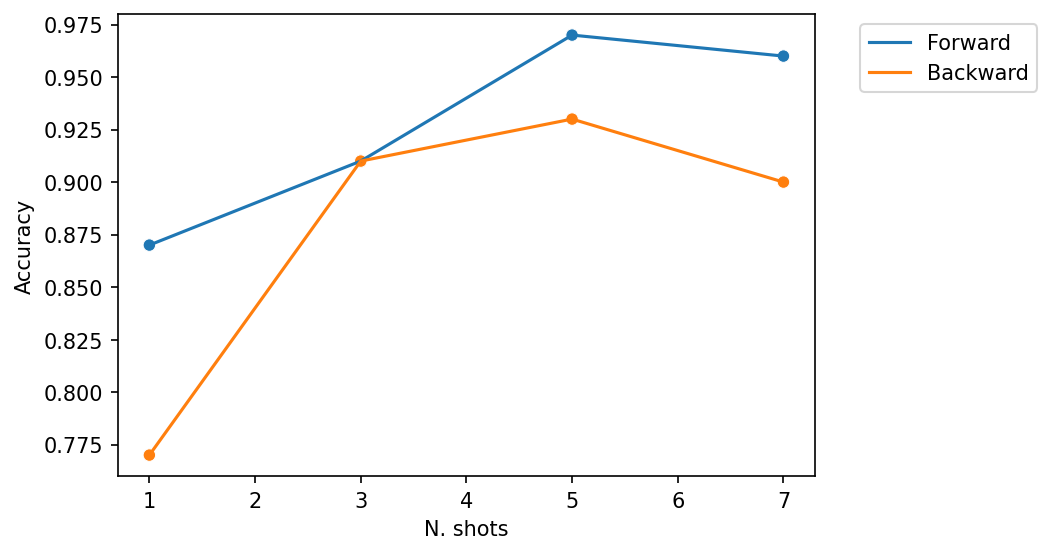

In [201]:
fig = plt.figure(figsize=(6, 4), dpi=150)

sns.lineplot(df, x='N. shots', y='Accuracy', hue='Backward')
sns.scatterplot(df, x='N. shots', y='Accuracy', hue='Backward')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[:len(handles)//2], labels=['Forward', 'Backward'], bbox_to_anchor=(1.05, 1), loc='upper left')

In [202]:
df = {
    'N. shots': [],
    'CoT': [],
    'Accuracy': []
}

for cot_lab in ['', '_cot']: 
    for shot_lab in ['1shot', '3shots', '5shots', '7shots']:
        print(f"{shot_lab}{cot_lab}")
        result = pd.read_csv(f"results/{model_label}/{shot_lab}{cot_lab}.csv")
        df['N. shots'].append(int(shot_lab[0]))
        df['CoT'].append(cot_lab == '_cot')
        df['Accuracy'].append(result['correct_pred'].mean())
        
        print(f"Correct CoT predictions: {result['correct_cot'].mean()}")
        print(f"Label CoT correlation: {(result['correct_pred'] * result['correct_cot']).mean() / min(result['correct_pred'].mean(), result['correct_cot'].mean())}")

df = pd.DataFrame(df)

1shot
Correct CoT predictions: 1.0
Label CoT correlation: 1.0
3shots
Correct CoT predictions: 1.0
Label CoT correlation: 1.0
5shots
Correct CoT predictions: 1.0
Label CoT correlation: 1.0
7shots
Correct CoT predictions: 1.0
Label CoT correlation: 1.0
1shot_cot
Correct CoT predictions: 0.64
Label CoT correlation: 0.984375
3shots_cot
Correct CoT predictions: 0.85
Label CoT correlation: 0.9294117647058824
5shots_cot
Correct CoT predictions: 0.81
Label CoT correlation: 1.0
7shots_cot
Correct CoT predictions: 0.87
Label CoT correlation: 0.9770114942528736


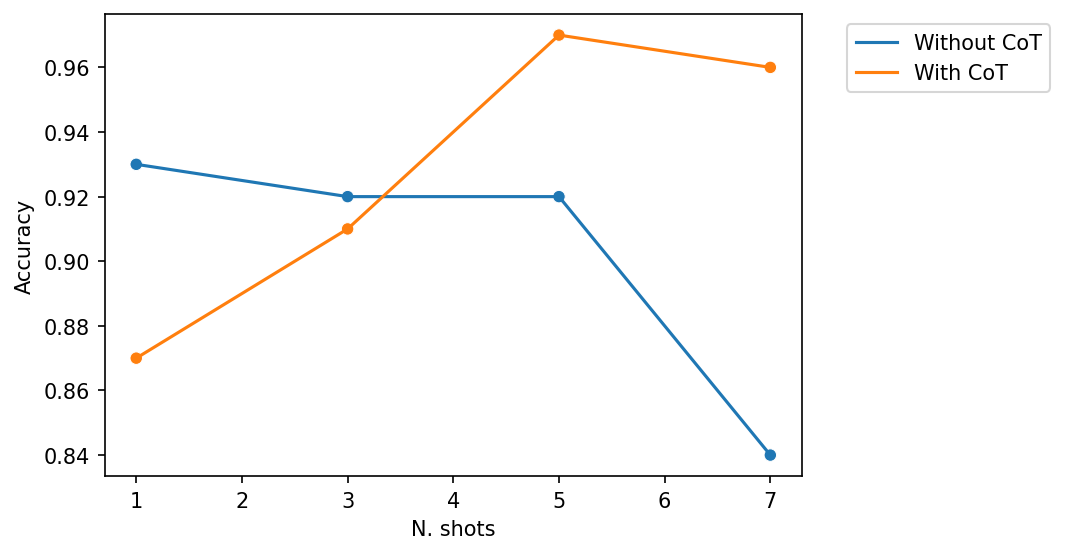

In [157]:
fig = plt.figure(figsize=(6, 4), dpi=150)

sns.lineplot(df, x='N. shots', y='Accuracy', hue='CoT')
sns.scatterplot(df, x='N. shots', y='Accuracy', hue='CoT')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[:len(handles)//2], labels=['Without CoT', 'With CoT'], bbox_to_anchor=(1.05, 1), loc='upper left')

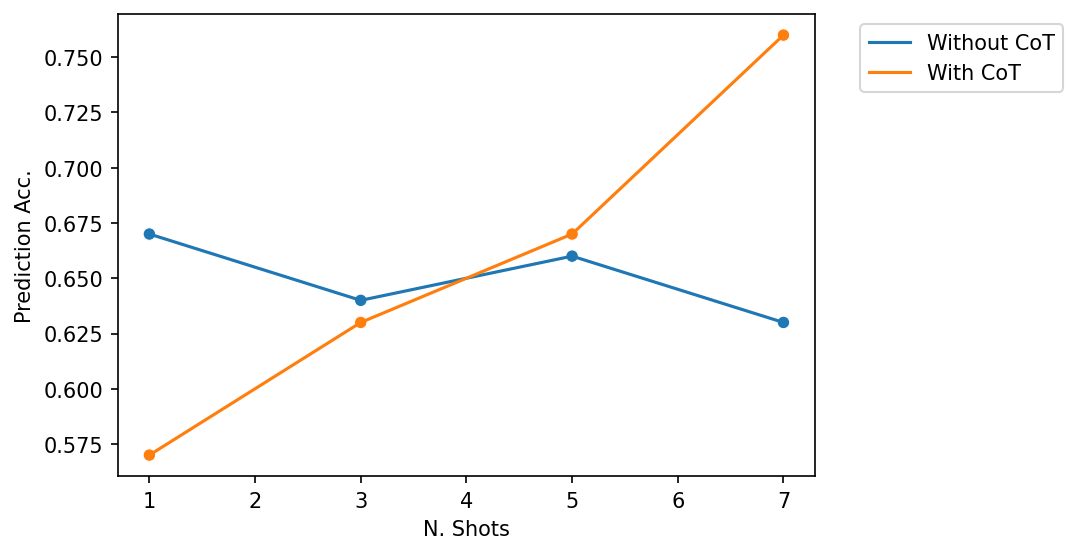

In [17]:
fig = plt.figure(figsize=(6, 4), dpi=150)

shots_results = pd.DataFrame({
    'N. Shots': [1, 3, 5, 7, 1, 3, 5, 7],
    'Prediction Acc.': [0.57, 0.63, 0.67, 0.76, 0.67, 0.64, 0.66, 0.63],
    'CoT Acc.': [0.14, 0.21, 0.22, 0.27, 0, 0, 0, 0],
    'Agreement': [0.643, 0.810, 0.955, 0.963, 0, 0, 0, 0],
    'With CoT': [True, True, True, True, False, False, False, False] 
})

sns.lineplot(shots_results, x='N. Shots', y='Prediction Acc.', hue='With CoT')
sns.scatterplot(shots_results, x='N. Shots', y='Prediction Acc.', hue='With CoT')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[:len(handles)//2], labels=['Without CoT', 'With CoT'], bbox_to_anchor=(1.05, 1), loc='upper left')

(0.0, 1.0)

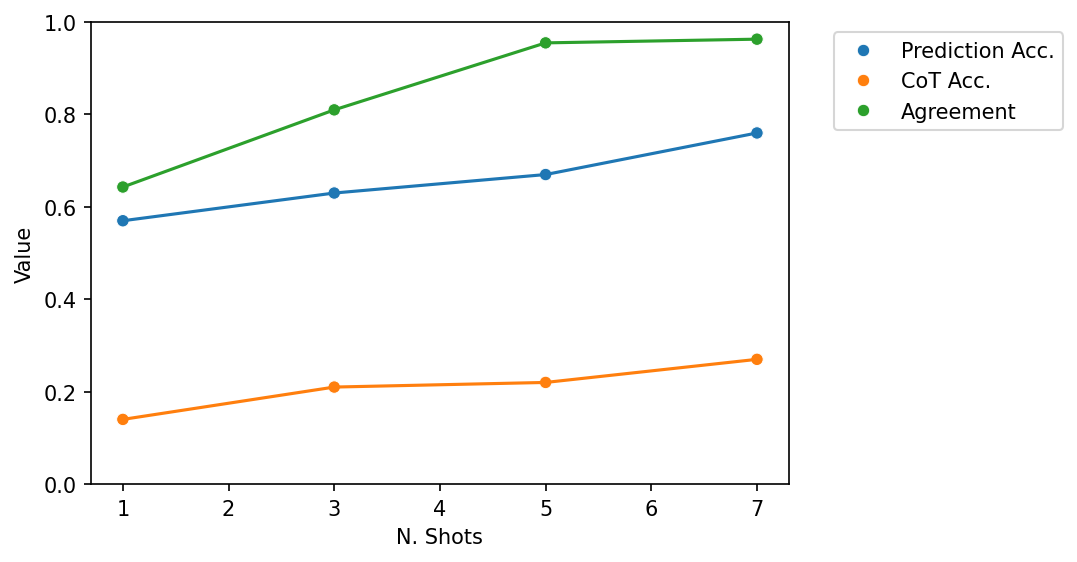

In [90]:
fig = plt.figure(figsize=(6, 4), dpi=150)
plot_df = shots_results.iloc[:4].drop('With CoT', axis=1).melt(id_vars='N. Shots', var_name='Score', value_name='Value')

sns.scatterplot(plot_df, x='N. Shots', y='Value', hue='Score')
sns.lineplot(plot_df, x='N. Shots', y='Value', hue='Score')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[:len(handles)//2], labels=labels[:len(labels)//2], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1)

### Error analysis

In [1]:
import pandas as pd

model_label = 'gemma-2b'

results = [
    pd.read_csv(f'results/{model_label}/1shot_cot.csv'),
    pd.read_csv(f'results/{model_label}/3shots_cot.csv'),
    pd.read_csv(f'results/{model_label}/5shots_cot.csv'),
    pd.read_csv(f'results/{model_label}/7shots_cot.csv')
]

In [5]:
import ast

mistakes = {
    '1': [],
    '3': [],
    '5': [],
    '7': []
}

for shots, df in zip([1, 3, 5, 7], results):

    df['correct_pred'] = df['label'] == df['pred']
    df['correct_cot'] = df.apply(check_cot, axis=1)
    
    cot_miss = df[(df['correct_cot'] == False) & (df['correct_pred'] == False)]
    
    for i in range(len(cot_miss)):
        gold, pred = cot_miss[["cot_gold", "cot_pred"]].iloc[i]
        gold = ast.literal_eval(gold)
        pred = ast.literal_eval(pred)
        for j, (gold_step, pred_step) in enumerate(zip(gold, pred)):
            if gold_step != pred_step:
                mistakes[str(shots)].append(j)
                break

In [6]:
for shot in mistakes:
    print(f"{100 - len(mistakes[shot])}% accuracy at {shot} shots")

62% accuracy at 1 shots
67% accuracy at 3 shots
68% accuracy at 5 shots
77% accuracy at 7 shots


In [7]:
plt.figure(figsize=(6, 4), dpi=150)

plot_df = pd.concat([
    pd.Series(mistakes['1'], name='CoT step').reset_index().groupby('CoT step').count(),
    pd.Series(mistakes['3'], name='CoT step').reset_index().groupby('CoT step').count(),
    pd.Series(mistakes['5'], name='CoT step').reset_index().groupby('CoT step').count(),
    pd.Series(mistakes['7'], name='CoT step').reset_index().groupby('CoT step').count()
], axis=1).fillna(0)
plot_df.columns = ['1 shot', '3 shots', '5 shots', '7 shots']
plot_df = plot_df.reset_index().melt(id_vars='CoT step', var_name='N. shots', value_name='Errors')

sns.lineplot(plot_df, x='CoT step', y='Errors', hue='N. shots')
sns.scatterplot(plot_df, x='CoT step', y='Errors', hue='N. shots')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[:len(handles)//2], labels=labels[:len(labels)//2], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks([0, 1, 2])
plt.show()

NameError: name 'plt' is not defined

In [8]:
import ast
all_species = ['grimpus', 'lorpus', 'wumpus', 'zumpus', 'sterpus', 'numpus', 'jompus', 'brimpus', 'yumpus', 'tumpus', 'dumpus', 'vumpus', 'rompus', 'lempus', 'gorpus', 'shumpus', 'impus']

def check_err(gold, pred, step):

    def count_species(pred):
        k = 0
        for s in all_species:
            if s in pred: k+=1
        return k

    def check_attribute(gold, pred):
        attr = gold.split()[-1][:-1]
        return attr in pred

    if step == 0:
        return "S1"
    elif step == 1:
        if "not" in gold and "not" not in pred:
            return "S2-lose_not"
        if "not" not in gold and "not" in pred:
            return "S2-add_not"
        if count_species(pred) > 1:
            return "S2-s2a"
        if not check_attribute(gold, pred):
            return "S2-miss_a"
    elif step == 2:
        if "not" in gold and "not" not in pred:
            return "S3-lose_not"
        if "not" not in gold and "not" in pred:
            return "S3-add_not"
        if count_species(pred) > 0:
            return "S3-s2a"
        if not check_attribute(gold, pred):
            return "S3-miss_a"

    return "C"
        
def evaluate_(row):
    cot_gold = ast.literal_eval(row['cot_gold'])
    cot_pred = ast.literal_eval(row['cot_pred'])
    
    r = ""
    
    for i, (g, p) in enumerate(zip(cot_gold, cot_pred)):
        if g != p:
            err = check_err(g, p, i)
        else:
            err = "C"

        r += err + "|"

    return r

In [9]:
dfs = []
for n_shots in ["1shot", "3shots", "5shots", "7shots"]:
    df = pd.read_csv(f'results/{model_label}/{n_shots}_cot.csv')
    df['correct_pred'] = df['label'] == df['pred']
    df['correct_cot'] = df.apply(check_cot, axis=1)

    df['errors'] = df.apply(evaluate_, axis=1)

    df['errors'] = df['errors'].apply(lambda x: x[:-1])
    df[['S1', 'S2', 'S3']] = df['errors'].str.split('|', expand=True)
    df['S1'] = df['S1'].apply(lambda x: 'S1-C' if x == 'C' else 'S1-miss_s')
    df['S2'] = df['S2'].apply(lambda x: 'S2-C' if x == 'C' else x)
    df['S3'] = df['S3'].apply(lambda x: 'S3-C' if x == 'C' else x)
    dfs.append(df[['S1', 'S2', 'S3', 'correct_pred']])

In [14]:
import pandas as pd
import plotly.graph_objects as go

df = dfs[3]

# Prepare the data for the Sankey diagram
all_labels = list(pd.unique(df[['S1', 'S2', 'S3', 'correct_pred']].values.ravel('K')))
label_dict = {label: i for i, label in enumerate(all_labels)}

sources = []
targets = []
values = []

# Define stages and their order
stages = ['S1', 'S2', 'S3', 'correct_pred']

# Count the flows between stages
for i in range(len(stages) - 1):
    stage = stages[i]
    next_stage = stages[i + 1]
    stage_counts = df.groupby([stage, next_stage]).size().reset_index(name='count')
    
    for _, row in stage_counts.iterrows():
        sources.append(label_dict[row[stage]])
        targets.append(label_dict[row[next_stage]])
        values.append(row['count'])

# Define node and link data for Sankey diagram
node = dict(
    pad = 15,
    thickness = 20,
    line = dict(color = "black", width = 0.5),
    label = all_labels,
)

link = dict(
    source = sources,
    target = targets,
    value = values
)

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(node=node, link=link)])
fig.update_layout(title_text="Observation Flow into Variables", font_size=10, width=800)
fig.show()